# Process and Analyse SSPALS

Create simulated SSPALS spectra for hi- and low-gain oscilloscope channels, 
combine together and analyse to find the delayed fraction.

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sspals

In [2]:
# simulate data
dt = 1e-9
t  = np.arange(-1.5E-7, 7.0E-7, dt)
sim = -sspals.sim(t, amp=0.5, eff=0.28)

h_noise = 0.002         # scale of noise to add to hi-gain channel
h_min = -0.05           # range of the hi-gain channel
h_max = 0.03
l_noise = 0.006         # scale of noise to add to low-gain channel
offset = 0.003          # add a random offset to both channels
repeats = 1000

# data
high = []
low = []
for i in range(repeats):
    high.append(np.clip(np.add(sim, 
            np.random.normal(np.random.rand() * offset, h_noise, len(sim))), h_min, h_max))
    low.append(np.add(sim, 
            np.random.normal(np.random.rand() * offset, l_noise, len(sim))))
high = np.array(high)
low = np.array(low)
print(np.shape(high))
print(np.shape(low))

(1000, 850)
(1000, 850)


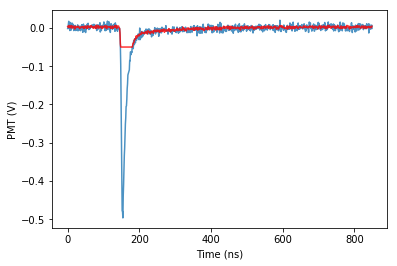

In [3]:
xdata = np.arange(len(high[0])) * dt

# plot
fig, ax = plt.subplots()
ax.plot(xdata * 1e9, low[0], alpha=0.8)
ax.plot(xdata * 1e9, high[0], alpha=0.8, c='r')

ax.set_xlabel('Time (ns)')
ax.set_ylabel('PMT (V)')

plt.show()

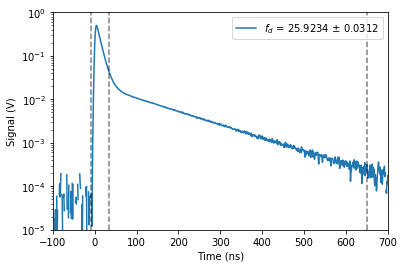

In [4]:
# combine high and low gain data
chmx = sspals.chmx(high, low)

# analyse
limits=[-1.0E-8, 3.5E-8, 6.5E-7]
df = sspals.sspals(chmx, dt, limits=limits, cfd_threshold=0.04)

# trigger
t0 = np.nanmean(df.t0)

# plot average
fig, ax = plt.subplots()
reps = df.DF.count()
ax.plot((xdata - t0) * 1e9, np.mean(chmx, 0), 
        label='$f_d$ = %.4f $\pm$ %.4f'%(100 * df.DF.mean(), 100 * df.DF.std()/ np.sqrt(reps)))

# show interation limits ABC
for lim in limits:
    ax.axvline(lim*1e9, c='k', ls='--', alpha=0.5)
ax.set_yscale('log')
ax.set_xlim(-100, 700)
ax.set_ylim(1e-5, 1)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Signal (V)')
ax.legend(loc=1)

plt.show()

In [5]:
# analysis
df.head()

,t0,AC,BC,DF
0,1.489274e-07,9.920426e-09,2.512863e-09,0.253302
1,1.489435e-07,9.697372e-09,2.320522e-09,0.239294
2,1.487877e-07,9.867928e-09,2.489094e-09,0.252241
3,1.490048e-07,1.033655e-08,2.942127e-09,0.284633
4,1.488579e-07,1.010736e-08,2.621986e-09,0.259414


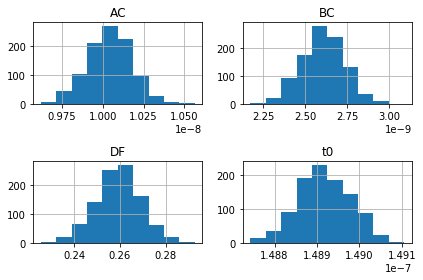

In [6]:
df.hist()
plt.tight_layout()
plt.show()